In [1]:
##导入实验依赖模块
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale


In [2]:
##载入示例数据集。载入Scikit-learn自带数据集手写数字识别集（Handwritten Digits Data Set）。
# 设定随机数种子
np.random.seed(42)
# 加载数据集
digits = load_digits()

In [3]:
##数据预处理。标准化数据，并获取数据集相关信息。
data = scale(digits.data)
# 解析数据集
# 数据集包含10个分类（手写数字1-10），1797个样本，特征维度为64维；
# 样本数，特征维度
n_samples, n_features = data.shape
# 类别数
n_digits = len(np.unique(digits.target))
labels = digits.target
sample_size = 300
print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))

n_digits: 10, 	 n_samples 1797, 	 n_features 64


In [4]:
##定义bench_k_means函数用以完成模型的训练及打印模型的聚类评估指标。
# 函数：训练并测试分类效果
def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

In [5]:
##分别构建三种不同的K-means聚类器
print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')
# 构建K-means分类器1: 初始化中心点为k-means++，传入以上函数				 

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)
			  
# 构建K-means分类器2：初始化中心点为random，传入以上函数
bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
# 构建K-means分类器3，利用PCA找到数据主轴，将其作为kmeans初始化中心点的方法，传入以上函数	
# 进行PCA降维
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.11s	69432	0.602	0.650	0.625	0.465	0.598	0.146
random   	0.10s	69694	0.669	0.710	0.689	0.553	0.666	0.147
PCA-based	0.02s	70804	0.671	0.698	0.684	0.561	0.668	0.118
__________________________________________________________________________________


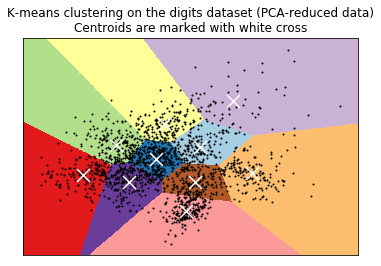

In [7]:
##聚类可视化。使用matplotlib可视化聚类结果（PCA降维到2维以便平面显示）。
reduced_data = PCA(n_components=2).fit_transform(data)
# 习题：修改此处参数
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
	   extent=(xx.min(), xx.max(), yy.min(), yy.max()),
	   cmap=plt.cm.Paired,
	   aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
	    marker='x', s=169, linewidths=3,
	    color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
	  'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()
